In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
df = pd.read_excel('C:\\Users\\HP\\Documents\\Veri Madenciligi\\modeleHazir_veri1.xlsx')

In [4]:
# Tüm sütunların gösterilmesi için ayar
pd.set_option('display.max_rows', None)

# Null değer sayısını yazdır
print(df.isnull().sum())

listingId                                0
price                                    0
room                                     0
livingRoom                               0
bathRoom                                 0
age                                      0
credit                                   0
barter                                   0
furnished                                0
roomAndLivingRoom                        0
onlineVisit                              0
hasBranded                               0
registerState                            0
image_count                              0
bulunan_yonler                           0
property_type                            0
inAttributes_count                       0
outAttributes_count                      0
locationAttributes_count                 0
inAttributes_count_is_missing            0
outAttributes_count_is_missing           0
locationAttributes_count_is_missing      0
price_category                           0
fee_is_miss

In [5]:
df['property_type'].value_counts()

property_type
Daire          1306
Villa           611
Müstakil Ev     155
Yazlık           47
Bina             21
Çiftlik Evi       6
Prefabrik         3
Bungalov          2
Köşk              2
Köy Evi           1
Name: count, dtype: int64

In [6]:
# List of property types to group as 'Diğer'
others = ['Köy Evi', 'Köşk', 'Bungalov', 'Prefabrik', 'Çiftlik Evi']

# Replace values in the DataFrame
df['property_type'] = df['property_type'].replace(others, 'Diğer')

# Now get the new counts
property_type_counts = df['property_type'].value_counts()

print(property_type_counts)

property_type
Daire          1306
Villa           611
Müstakil Ev     155
Yazlık           47
Bina             21
Diğer            14
Name: count, dtype: int64


In [7]:
# Step1: Select features and target
# Drop columns that are identifiers or clearly non-predictive
cols_to_drop = ['listingId', 'yapiDurumu', 'registerState', 'usage_name', 'yakit', 'residence_name', 'bulunan_yonler'] # --> Bunlara encoding yapildi
X = df.drop(columns=cols_to_drop + ['property_type','property_type_branded_ratio']) # --> Over fitting'e sebeb olmasin diye sildik
y = df['property_type']

# Step 2: Preprocess target variable (Label encoding)
# Property types are turned into numbers (like 0, 1, 2...) so the computer can understand them.
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Optional: Show class mapping
print("\nClass mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")


Class mapping:
0: Bina
1: Daire
2: Diğer
3: Müstakil Ev
4: Villa
5: Yazlık


In [8]:
# Step 3: Split into train+validation (80%) and test (20%) - STRATIFIED
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [9]:
# Step 4: Identify feature types
numerical_cols = X_train_val.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train_val.select_dtypes(exclude=np.number).columns.tolist()

print(f"Numerical Columns: {numerical_cols}")
print()
print(f"Categorical Columns: {categorical_cols}")

Numerical Columns: ['price', 'room', 'livingRoom', 'bathRoom', 'age', 'image_count', 'inAttributes_count', 'outAttributes_count', 'locationAttributes_count', 'inAttributes_count_is_missing', 'outAttributes_count_is_missing', 'locationAttributes_count_is_missing', 'days_since_update', 'duration', 'tier', 'distance_to_sakarya_center_km', 'distance_to_karasu_km', 'distance_to_sapanca_km', 'distance_to_sakarya_university_km', 'floorCount', 'floorNameFloat', 'floorCountFloat', 'floorRatio', 'netSqm', 'grossSqm', 'sqm_fark', 'rental_amount', 'is_outlier_price', 'tier_brand_ratio', 'tier_is_branded_only', 'county_brand_ratio', 'direction_encoded', 'yon_sayisi', 'yapiDurumu_encoded', 'yakit_encoded', 'registerState_encoded']

Categorical Columns: ['credit', 'barter', 'furnished', 'roomAndLivingRoom', 'onlineVisit', 'hasBranded', 'price_category', 'fee_is_missing', 'Stale_corrected', 'area_name', 'county_name', 'sakarya_center_category', 'karasu_category', 'sapanca_category', 'sakarya_universit

In [10]:
# Step 5: Create preprocessing pipeline

# For number: If one is missing, take middle value.
# Then stretch numbers to a similar scale.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For word clues: If one is missing, fill it in with the most common one.
# Then turn words into little codes (one-hot encoding).
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


# Get one-hot encoded feature names
preprocessor.fit(X_train_val) # Fit the preprocessor first
onehot_features = preprocessor.named_transformers_['cat']\
                  .named_steps['onehot']\
                  .get_feature_names_out(categorical_cols)

print("One-hot encoded features:\n", onehot_features)

One-hot encoded features:
 ['credit_False' 'credit_True' 'barter_False' 'barter_True'
 'furnished_False' 'furnished_True' 'roomAndLivingRoom_1+0'
 'roomAndLivingRoom_1+1' 'roomAndLivingRoom_13+1' 'roomAndLivingRoom_2'
 'roomAndLivingRoom_2+1' 'roomAndLivingRoom_2+2' 'roomAndLivingRoom_3'
 'roomAndLivingRoom_3+1' 'roomAndLivingRoom_3+2' 'roomAndLivingRoom_3+3'
 'roomAndLivingRoom_4' 'roomAndLivingRoom_4+1' 'roomAndLivingRoom_4+2'
 'roomAndLivingRoom_5+1' 'roomAndLivingRoom_5+2' 'roomAndLivingRoom_5+3'
 'roomAndLivingRoom_6+1' 'roomAndLivingRoom_6+2' 'roomAndLivingRoom_6+3'
 'roomAndLivingRoom_7+1' 'roomAndLivingRoom_7+2' 'roomAndLivingRoom_7+3'
 'roomAndLivingRoom_8+1' 'roomAndLivingRoom_8+2' 'roomAndLivingRoom_8+3'
 'roomAndLivingRoom_9+2' 'onlineVisit_False' 'onlineVisit_True'
 'hasBranded_False' 'hasBranded_True' 'price_category_düşük'
 'price_category_orta' 'price_category_yüksek' 'fee_is_missing_False'
 'fee_is_missing_True' 'Stale_corrected_False' 'Stale_corrected_True'
 'area_nam

In [11]:
# Step 6: Create main pipeline with Logistic Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial', 
        solver='lbfgs', 
        max_iter=1000, 
        #class_weight='balanced'
    ))
])

# Step 7: Set up 10-fold stratified cross-validation ON TRAIN/VAL DATA
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Step 8: Cross-validate on train/validation data
y_train_val_pred = cross_val_predict(pipeline, X_train_val, y_train_val, cv=skf)
scores = cross_val_score(pipeline, X_train_val, y_train_val, cv=skf, scoring='accuracy')

# Step 9: Evaluate cross-validation metrics
cv_accuracy = accuracy_score(y_train_val, y_train_val_pred)
cv_precision = precision_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)
cv_recall = recall_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)
cv_f1 = f1_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)

print("Cross-Validation on Train/Validation Data:")
print(f"Individual Fold Accuracies: {scores}")
print(f"Mean CV Accuracy: {np.mean(scores):.4f}")
print("\nCross-Validation Metrics (Macro Average):")
print(f"Accuracy : {cv_accuracy:.4f}")
print(f"Precision: {cv_precision:.4f}")
print(f"Recall   : {cv_recall:.4f}")
print(f"F1 Score : {cv_f1:.4f}")

# Step 10: Final evaluation on held-out test set
print("\nEvaluation on Held-Out Test Set:")
pipeline.fit(X_train_val, y_train_val)  # Train on ALL train+validation data
y_test_pred = pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall   : {test_recall:.4f}")
print(f"Test F1 Score : {test_f1:.4f}")

Cross-Validation on Train/Validation Data:
Individual Fold Accuracies: [0.90751445 0.89017341 0.93063584 0.94767442 0.93023256 0.91860465
 0.9127907  0.9244186  0.93604651 0.91860465]
Mean CV Accuracy: 0.9217

Cross-Validation Metrics (Macro Average):
Accuracy : 0.9216
Precision: 0.7287
Recall   : 0.6137
F1 Score : 0.6459

Evaluation on Held-Out Test Set:
Test Accuracy : 0.9142
Test Precision: 0.7583
Test Recall   : 0.5684
Test F1 Score : 0.5986


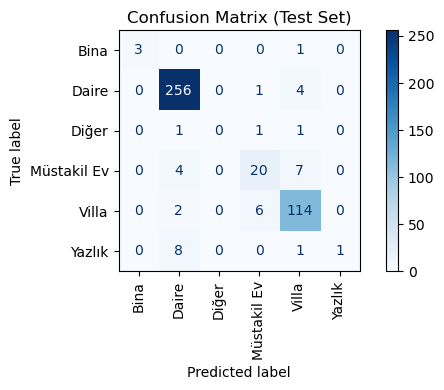

In [37]:
# Step 11: Confusion Matrix for Test Set
# Get classes present in test set
present_classes = np.unique(np.concatenate([y_test, y_test_pred]))
class_names = le.classes_[present_classes]

cm = confusion_matrix(y_test, y_test_pred, labels=present_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

<h3> Property type'teki dengesizliği yüzünden F1 skoru düşük çıkıyor. Bu yüzden SMOTE kullanılacak. </h3>

### 🛠️ How SMOTE Works:
1. Looks at your minority class (the class with few samples).

2. Picks a sample from it.

3. Finds its nearest neighbors (similar samples).

5. Creates new, synthetic (fake but realistic) examples in between them.

#### So instead of just duplicating data (which can cause overfitting), it creates slightly different, believable examples.

In [29]:
# Step 6: Define pipeline with SMOTE inside (using ImbPipeline)
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('classifier', LogisticRegression(
        multi_class='multinomial', 
        max_iter=1000, 
        class_weight='balanced',
        random_state=42
    ))
])

# Step 7: Set up 10-fold stratified cross-validation on train/val data
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Step 8: Cross-validate on train/val data
y_train_val_pred = cross_val_predict(pipeline, X_train_val, y_train_val, cv=skf)
scores = cross_val_score(pipeline, X_train_val, y_train_val, cv=skf, scoring='accuracy')

# Step 9: Evaluate cross-validation metrics
cv_accuracy = accuracy_score(y_train_val, y_train_val_pred)
cv_precision = precision_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)
cv_recall = recall_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)
cv_f1 = f1_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)

print("Cross-Validation Results (Train/Validation Data):")
print(f"Individual Fold Accuracies: {scores}")
print(f"Mean CV Accuracy: {np.mean(scores):.4f}")
print("\nCross-Validation Metrics (Macro Average):")
print(f"Accuracy : {cv_accuracy:.4f}")
print(f"Precision: {cv_precision:.4f}")
print(f"Recall   : {cv_recall:.4f}")
print(f"F1 Score : {cv_f1:.4f}")

# Step 10: Final evaluation on held-out test set
print("\nEvaluation on Held-Out Test Set:")
pipeline.fit(X_train_val, y_train_val)  # Train on ALL train+val data
y_test_pred = pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall   : {test_recall:.4f}")
print(f"Test F1 Score : {test_f1:.4f}")

Cross-Validation Results (Train/Validation Data):
Individual Fold Accuracies: [0.83815029 0.82080925 0.87861272 0.88953488 0.83139535 0.83139535
 0.80813953 0.84883721 0.84883721 0.87209302]
Mean CV Accuracy: 0.8468

Cross-Validation Metrics (Macro Average):
Accuracy : 0.8468
Precision: 0.5672
Recall   : 0.6381
F1 Score : 0.5859

Evaluation on Held-Out Test Set:
Test Accuracy : 0.8724
Test Precision: 0.7960
Test Recall   : 0.8240
Test F1 Score : 0.7829


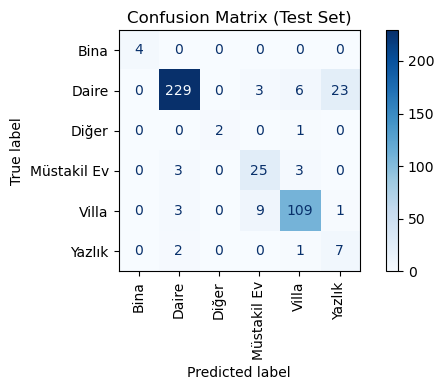

In [14]:
# Step 11: Confusion Matrix for Test Set
# Get classes present in test set
present_classes = np.unique(np.concatenate([y_test, y_test_pred]))
class_names = le.classes_[present_classes]

cm = confusion_matrix(y_test, y_test_pred, labels=present_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

<h3> İyileştirme için Hiperparametre Ayarlama (GridSearchCV) Denecektir : </h3>

In [26]:
# Step 6: Define pipeline with GridSearchCV
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial', 
        max_iter=3000, 
        class_weight='balanced',
        solver='lbfgs',
        random_state=42
    ))
])

# Step 7: Set up parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'newton-cg'],
    'classifier__max_iter': [3000]
}

# Step 8: Stratified 10-fold CV and grid search
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_val, y_train_val)

print("Best Parameters:", grid_search.best_params_)

# Step 9: Evaluate CV performance with best estimator
best_pipeline = grid_search.best_estimator_
y_train_val_pred = cross_val_predict(best_pipeline, X_train_val, y_train_val, cv=skf)

cv_accuracy = accuracy_score(y_train_val, y_train_val_pred)
cv_precision = precision_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)
cv_recall = recall_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)
cv_f1 = f1_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)

print("\nCross-Validation Metrics (Macro Average) with Best Model:")
print(f"Accuracy : {cv_accuracy:.4f}")
print(f"Precision: {cv_precision:.4f}")
print(f"Recall   : {cv_recall:.4f}")
print(f"F1 Score : {cv_f1:.4f}")

# Step 10: Final evaluation on held-out test set
best_pipeline.fit(X_train_val, y_train_val)
y_test_pred = best_pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print("\nEvaluation on Held-Out Test Set (Best Model):")
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall   : {test_recall:.4f}")
print(f"Test F1 Score : {test_f1:.4f}")

Best Parameters: {'classifier__C': 10, 'classifier__max_iter': 3000, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

Cross-Validation Metrics (Macro Average) with Best Model:
Accuracy : 0.8491
Precision: 0.5927
Recall   : 0.6621
F1 Score : 0.6093

Evaluation on Held-Out Test Set (Best Model):
Test Accuracy : 0.8747
Test Precision: 0.7912
Test Recall   : 0.7676
Test F1 Score : 0.7541


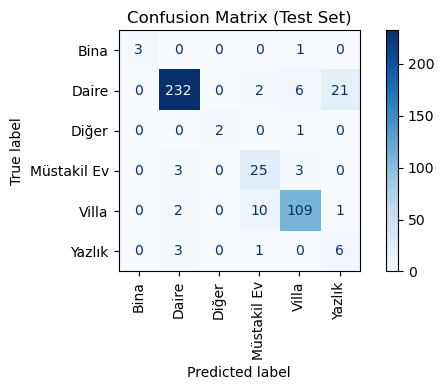

In [27]:
# Step 11: Confusion Matrix for Test Set
# Get classes present in test set
present_classes = np.unique(np.concatenate([y_test, y_test_pred]))
class_names = le.classes_[present_classes]

cm = confusion_matrix(y_test, y_test_pred, labels=present_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

<h3> İyileştirme için SMOTE + Hiperparametre Ayarlama (GridSearchCV) Denecektir : </h3>

In [23]:
# Step 6: Define pipeline with SMOTETomek
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('classifier', LogisticRegression(
        multi_class='multinomial', 
        max_iter=3000, 
        class_weight='balanced',
        solver='lbfgs',
        random_state=42
    ))
])

# Step 7: Set up parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'newton-cg'],
    'classifier__max_iter': [3000]
}

# Step 8: Stratified 10-fold CV and grid search
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_val, y_train_val)

print("Best Parameters:", grid_search.best_params_)

# Step 9: Evaluate CV performance with best estimator
best_pipeline = grid_search.best_estimator_
y_train_val_pred = cross_val_predict(best_pipeline, X_train_val, y_train_val, cv=skf)

cv_accuracy = accuracy_score(y_train_val, y_train_val_pred)
cv_precision = precision_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)
cv_recall = recall_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)
cv_f1 = f1_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)

print("\nCross-Validation Metrics (Macro Average) with Best Model:")
print(f"Accuracy : {cv_accuracy:.4f}")
print(f"Precision: {cv_precision:.4f}")
print(f"Recall   : {cv_recall:.4f}")
print(f"F1 Score : {cv_f1:.4f}")

# Step 10: Final evaluation on held-out test set
best_pipeline.fit(X_train_val, y_train_val)
y_test_pred = best_pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print("\nEvaluation on Held-Out Test Set (Best Model):")
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall   : {test_recall:.4f}")
print(f"Test F1 Score : {test_f1:.4f}")

Best Parameters: {'classifier__C': 10, 'classifier__max_iter': 3000, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

Cross-Validation Metrics (Macro Average) with Best Model:
Accuracy : 0.8549
Precision: 0.5707
Recall   : 0.6161
F1 Score : 0.5818

Evaluation on Held-Out Test Set (Best Model):
Test Accuracy : 0.8794
Test Precision: 0.7391
Test Recall   : 0.7441
Test F1 Score : 0.7291


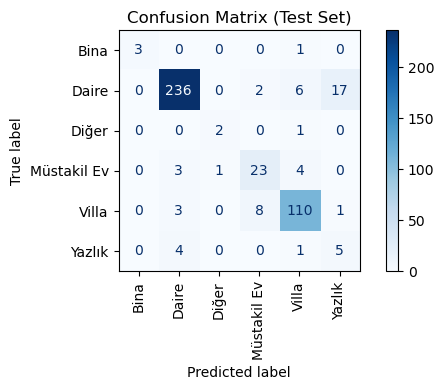

In [25]:
# Step 11: Confusion Matrix for Test Set
# Get classes present in test set
present_classes = np.unique(np.concatenate([y_test, y_test_pred]))
class_names = le.classes_[present_classes]

cm = confusion_matrix(y_test, y_test_pred, labels=present_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

<h3> İyileştirme için Feature Selection + SMOTE Denecektir : </h3>

In [50]:
from sklearn.feature_selection import SelectKBest, f_classif

# Step 6: Define pipeline with SMOTE inside (using ImbPipeline)
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=90)),  # Keep top 90 features
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('classifier', LogisticRegression(
        multi_class='multinomial', 
        max_iter=1000, 
        class_weight='balanced',
        random_state=42
    ))
])

# Step 7: Set up 10-fold stratified cross-validation on train/val data
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Step 8: Cross-validate on train/val data
y_train_val_pred = cross_val_predict(pipeline, X_train_val, y_train_val, cv=skf)
scores = cross_val_score(pipeline, X_train_val, y_train_val, cv=skf, scoring='accuracy')

# Step 9: Evaluate cross-validation metrics
cv_accuracy = accuracy_score(y_train_val, y_train_val_pred)
cv_precision = precision_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)
cv_recall = recall_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)
cv_f1 = f1_score(y_train_val, y_train_val_pred, average='macro', zero_division=0)

print("Cross-Validation Results (Train/Validation Data):")
print(f"Individual Fold Accuracies: {scores}")
print(f"Mean CV Accuracy: {np.mean(scores):.4f}")
print("\nCross-Validation Metrics (Macro Average):")
print(f"Accuracy : {cv_accuracy:.4f}")
print(f"Precision: {cv_precision:.4f}")
print(f"Recall   : {cv_recall:.4f}")
print(f"F1 Score : {cv_f1:.4f}")

# Step 10: Final evaluation on held-out test set
pipeline.fit(X_train_val, y_train_val)  # Train on ALL train+val data
y_test_pred = pipeline.predict(X_test)
print("\nEvaluation on Held-Out Test Set:")

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall   : {test_recall:.4f}")
print(f"Test F1 Score : {test_f1:.4f}")

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 29 133 178] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 29 133 186] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 29 136] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserW

Cross-Validation Results (Train/Validation Data):
Individual Fold Accuracies: [0.80924855 0.79768786 0.83815029 0.85465116 0.80813953 0.83139535
 0.78488372 0.84883721 0.81395349 0.84302326]
Mean CV Accuracy: 0.8230

Cross-Validation Metrics (Macro Average):
Accuracy : 0.8230
Precision: 0.5838
Recall   : 0.6712
F1 Score : 0.6001


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 29 136] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



Evaluation on Held-Out Test Set:
Test Accuracy : 0.8237
Test Precision: 0.7048
Test Recall   : 0.7807
Test F1 Score : 0.7159


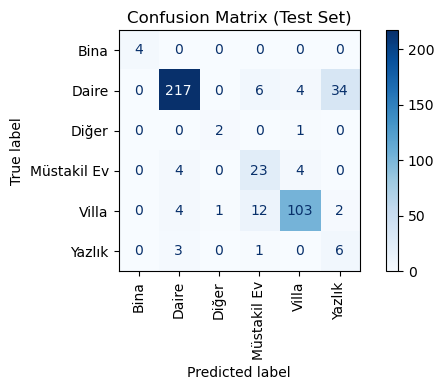

In [51]:
# Step 11: Confusion Matrix for Test Set
# Get classes present in test set
present_classes = np.unique(np.concatenate([y_test, y_test_pred]))
class_names = le.classes_[present_classes]

cm = confusion_matrix(y_test, y_test_pred, labels=present_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

#### Property type tahmin eden Lojistik Regresyon modelindeki iyileştirmeler sonucunda:
##### Önceki sonuçlar: Accuracy : 0.9142 - F1 Score : 0.5986

1. SOMOTE: Accuracy : 0.8724 - F1 Score : 0.7829

2. GridSearchCV: Accuracy : 0.8747 - F1 Score : 0.7541

3. SMOTE + GridSearchCV: Accuracy : 0.8794 - F1 Score : 0.7291

4. SMOTE + Feature Selection: Accuracy : 0.8237 - F1 Score : 0.7159

##### En iyi veren sonuç SOMOTE

<h3> En iyi veren sonucun learning curve (Lojistik Regresyon + SMOTE) : </h3>

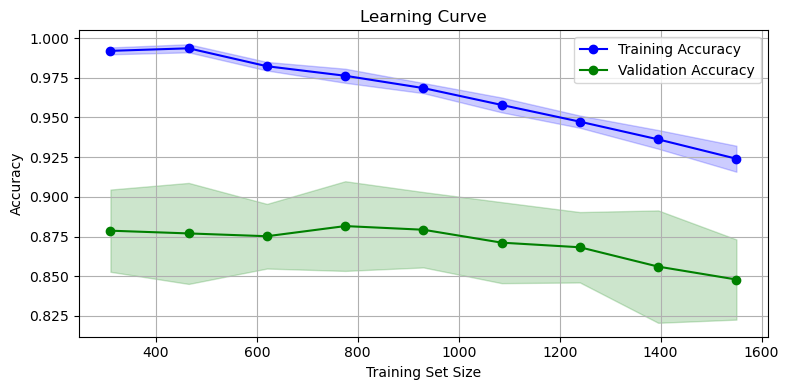

In [15]:
from sklearn.model_selection import learning_curve

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    pipeline, X_train_val, y_train_val,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 increments from 10% to 100%
    cv=skf,
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

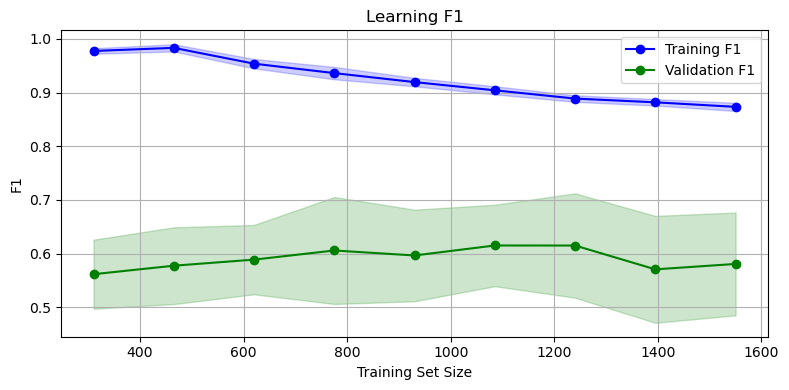

In [17]:
from sklearn.model_selection import learning_curve

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    pipeline, X_train_val, y_train_val,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 increments from 10% to 100%
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1  # Use all available cores
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training F1')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation F1')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

plt.title('Learning F1')
plt.xlabel('Training Set Size')
plt.ylabel('F1')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Öğrenme Eğrisinin Olumlu Yönleri:

1. Yakınsama: Eğitim ve doğrulama doğruluk eğrileri, eğitim seti boyutu arttıkça yakınsıyor gibi görünüyor. Bu, modelin etkili bir şekilde öğrendiğinin iyi bir göstergesidir.

2. Yüksek doğruluk ve F1 skoru: Hem eğitim hem de doğrulama doğrulukları (yaklaşık0.90-1.00 arası) ve F1 skorları (yaklaşık 0.85–1.0 arası) oldukça yüksek, bu da modelin iyi performans gösterdiğini belirtiyor.

3. Büyük Bir Açık Yok: Eğitim ve doğrulama için doğrulukları ve F1 skorları arasında büyük bir fark görünmüyor, bu da modelin aşırı öğrenme (overfitting) yapmadığını gösteriyor.